# 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

In [2]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
train = ImageDataGenerator(rescale = 1.0/255)
validation = ImageDataGenerator(rescale = 1.0/255)

In [4]:
train_dataset = train.flow_from_directory("C:/Users/lamim/Desktop/N_Thesis/split_dataset3/train",
                                          target_size = (224,224),
                                          batch_size = 32,
                                          class_mode = 'categorical')
validation_dataset = validation.flow_from_directory("C:/Users/lamim/Desktop/N_Thesis/split_dataset3/val",
                                          target_size = (224,224),
                                          batch_size = 32,
                                          class_mode = 'categorical')

Found 8790 images belonging to 2 classes.
Found 1120 images belonging to 2 classes.


In [5]:
train_dataset.class_indices

{'BMR': 0, 'RASH': 1}

In [6]:
validation_dataset.class_indices

{'BMR': 0, 'RASH': 1}

In [7]:
train_dataset.classes

array([0, 0, 0, ..., 1, 1, 1])

In [8]:
validation_dataset.classes

array([0, 0, 0, ..., 1, 1, 1])

In [9]:
class CutMixImageDataGenerator(tf.keras.utils.Sequence):
    """Custom ImageDataGenerator that applies CutMix augmentation."""
    def __init__(self, generator, batch_size, beta=1.0):
        self.generator = generator
        self.batch_size = batch_size
        self.beta = beta

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        images, labels = self.generator[index]  # Get a batch

        # Sample lambda from Beta distribution
        lam = np.random.beta(self.beta, self.beta)

        # Generate random indices for CutMix
        rand_index = np.random.permutation(self.batch_size)

        # Mix images
        mixed_images = lam * images + (1 - lam) * images[rand_index]
        
        # Mix labels
        mixed_labels = lam * labels + (1 - lam) * labels[rand_index]

        return mixed_images, mixed_labels


In [10]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.regularizers import l2

# Load the Xception model with pretrained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Build the updated model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Feature reduction
    Dropout(0.2),  # Add dropout for regularization
    Dense(2, activation='softmax', kernel_regularizer=l2(0.01))  # Output layer for 2 classes
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Initial learning rate
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# ============================
# 📉 Step 4: Learning Rate Scheduler
# ============================
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6, verbose=1)

# ============================
# 🚀 Step 5: Train Model with CutMix
# ============================
history = model.fit(
    train_dataset,  # CutMix-applied dataset
    validation_data=validation_dataset,  # Validation remains unchanged
    epochs=10,
    callbacks=[lr_scheduler]  # Added learning rate scheduler
)


Epoch 1/10


C:\Users\lamim\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


275/275 ━━━━━━━━━━━━━━━━━━━━ 213s 739ms/step - accuracy: 0.6120 - loss: 0.7022 - precision: 0.6120 - recall: 0.6120 - val_accuracy: 0.8223 - val_loss: 0.4255 - val_precision: 0.8223 - val_recall: 0.8223 - learning_rate: 0.0010
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 201s 730ms/step - accuracy: 0.7789 - loss: 0.4834 - precision: 0.7789 - recall: 0.7789 - val_accuracy: 0.8357 - val_loss: 0.3991 - val_precision: 0.8357 - val_recall: 0.8357 - learning_rate: 0.0010
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 200s 726ms/step - accuracy: 0.7809 - loss: 0.4725 - precision: 0.7809 - recall: 0.7809 - val_accuracy: 0.8062 - val_loss: 0.4143 - val_precision: 0.8062 - val_recall: 0.8062 - learning_rate: 0.0010
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.7939 - loss: 0.4539 - precision: 0.7939 - recall: 0.7939
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
275/275 ━━━━━━━━━━━━━━━━━━━━ 200s 727ms/step - accuracy: 0.7939 - loss: 0.4539 - precision: 0.79

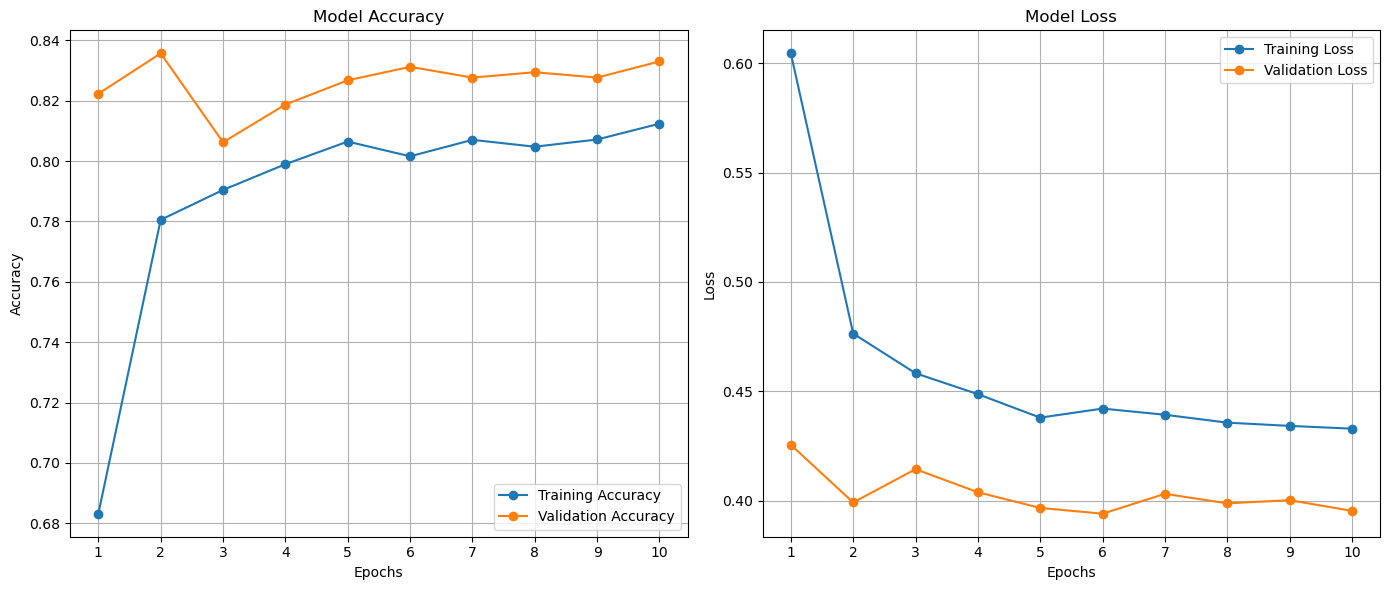

Plot saved to: C:\Users\lamim\Desktop\N_Thesis\BMR_CNN\RESULT_VGG_16\training_plot.png


In [11]:
import matplotlib.pyplot as plt
import os
import csv

# Example: extracting history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

# Create an output directory if you like
output_dir = "my_results"
os.makedirs(output_dir, exist_ok=True)

# Save your CSV logs (optional, if desired)
csv_path = os.path.join(output_dir, "training_log.csv")
with open(csv_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Epoch", "Train Accuracy", "Val Accuracy", "Train Loss", "Val Loss"])
    for epoch in epochs:
        writer.writerow([
            epoch,
            train_accuracy[epoch-1],
            val_accuracy[epoch-1],
            train_loss[epoch-1],
            val_loss[epoch-1]
        ])

# Plot
plt.figure(figsize=(14, 6))

# Subplot for Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.grid()

# Subplot for Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid()

plt.tight_layout()
# Suppose you want a folder "RESULT_DenseNet121" + a filename "training_plot.png"
output_dir = r"C:\Users\lamim\Desktop\N_Thesis\BMR_CNN\RESULT_VGG_16"
os.makedirs(output_dir, exist_ok=True)  # Create folder if needed

fig_path = os.path.join(output_dir, "training_plot.png")
plt.savefig(fig_path, dpi=300)
plt.show()

print(f"Plot saved to: {fig_path}")


In [12]:
import os

final_epoch = len(train_accuracy)
final_train_acc = train_accuracy[-1]
final_val_acc = val_accuracy[-1]
final_train_loss = train_loss[-1]
final_val_loss = val_loss[-1]

print("Final Epoch:", final_epoch)
print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")


Final Epoch: 10
Training Accuracy: 0.8124
Validation Accuracy: 0.8330


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1.0/255)  # Normalize test images

test_dataset = test_datagen.flow_from_directory(
    "C:/Users/lamim/Desktop/N_Thesis/split_dataset3/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 1130 images belonging to 2 classes.


In [14]:
results = model.evaluate(test_dataset)  # Evaluate the test dataset
test_acc = results[1] 

print(f"Test Accuracy: {test_acc:.4f}")

C:\Users\lamim\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 638ms/step - accuracy: 0.8177 - loss: 0.4091 - precision: 0.8177 - recall: 0.8177
Test Accuracy: 0.7776


In [15]:
import os

# Extract final training and validation metrics
final_epoch = len(train_accuracy)
final_train_acc = train_accuracy[-1]
final_val_acc = val_accuracy[-1]
final_train_loss = train_loss[-1]
final_val_loss = val_loss[-1]

# Extract final validation precision & recall from training history
final_val_precision = history.history["val_precision"][-1]  # Validation Precision
final_val_recall = history.history["val_recall"][-1]  # Validation Recall

# Evaluate the model on test dataset
test_results = model.evaluate(test_dataset)  # Returns test loss, accuracy, precision, recall

# Extract test metrics
test_loss = test_results[0]  # Test loss
test_acc = test_results[1]  # Test accuracy
test_precision = test_results[2]  # Test precision
test_recall = test_results[3]  # Test recall

# Print all results
print("Final Epoch:", final_epoch)
print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")
print(f"Validation Precision: {final_val_precision:.4f}")
print(f"Validation Recall: {final_val_recall:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

output_dir = "C:/Users/lamim/Desktop/N_Thesis/BMR_CNN/RESULT_Xception1"

36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 641ms/step - accuracy: 0.8177 - loss: 0.4091 - precision: 0.8177 - recall: 0.8177
Final Epoch: 10
Training Accuracy: 0.8124
Validation Accuracy: 0.8330
Validation Precision: 0.8330
Validation Recall: 0.8330
Test Accuracy: 0.7776


In [16]:
import tensorflow as tf
import numpy as np

# Print Model Summary
model.summary()

# Count Trainable and Non-Trainable Parameters
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])

# Print Details
print("\n================ MODEL DETAILS ================")
print(f"Total Parameters: {trainable_params + non_trainable_params}")
print(f"Trainable Parameters: {trainable_params}")
print(f"Non-Trainable Parameters: {non_trainable_params}")
print(f"Number of Layers: {len(model.layers)}")
print("\n===============================================")

# Print Layer-wise Trainable Status
print("\nLayer-wise Trainability:")
for layer in model.layers:
    print(f"{layer.name}: Trainable = {layer.trainable}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,039,554 (26.85 MB)

 Trainable params: 2,050 (8.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)


================ MODEL DETAILS ================
Total Parameters: 7039554
Trainable Parameters: 2050
Non-Trainable Parameters: 7037504
Number of Layers: 4


Layer-wise Trainability:
densenet121: Trainable = False
global_average_pooling2d: Trainable = True
dropout: Trainable = True
dense: Trainable = True


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report



In [18]:
# Get true labels from the test dataset
true_labels = test_dataset.classes  # Assuming your test dataset is from flow_from_directory

# Predict class probabilities
y_pred_probs = model.predict(test_dataset)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)


36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 740ms/step


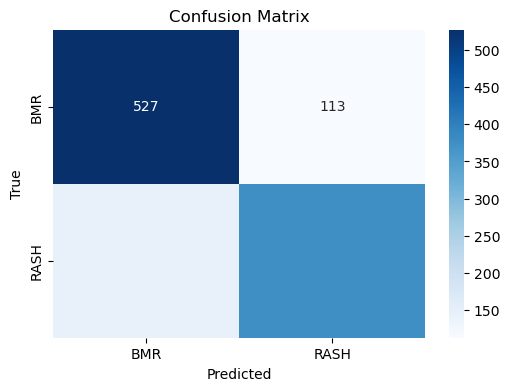

In [19]:
# Generate confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Define class names
class_names = list(test_dataset.class_indices.keys())  # ['BMR', 'RASH']

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [20]:
print("Classification Report:")
print(classification_report(true_labels, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

         BMR       0.78      0.82      0.80       620
        RASH       0.77      0.72      0.74       510

    accuracy                           0.78      1130
   macro avg       0.78      0.77      0.77      1130
weighted avg       0.78      0.78      0.78      1130



In [21]:
# Evaluate model on test dataset
test_results = model.evaluate(test_dataset)

# Extract values
test_loss = test_results[0]   # Test loss
test_acc = test_results[1]    # Test accuracy
test_precision = test_results[2]  # Test precision
test_recall = test_results[3]     # Test recall

# Print results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 673ms/step - accuracy: 0.8177 - loss: 0.4091 - precision: 0.8177 - recall: 0.8177
Test Loss: 0.4516
Test Accuracy: 0.7776
Test Precision: 0.7776
Test Recall: 0.7776
